# Automated Data Quality Analyst Agent

This notebook builds an end-to-end data-quality analysis workflow.  
It profiles a dataset, generates visuals, and uses Gemini to produce structured recommendations.  
The final output is a consolidated JSON report containing profiling results, visual paths, and LLM-based remediation suggestions.

---

## Notebook Structure

### 1. Parameters  
Configurable paths and model settings.

### 2. Reproducibility  
Random seed and environment versions.

### 3. Install & Imports  
Required libraries for profiling, visuals, and Gemini.

### 4. Secrets Management  
Loads the Gemini API key from Kaggle Secrets.

### 5. Utility Helpers  
Functions for safe JSON loading and output folders.

### 6. Dataset Loading  
Loads `sample_current.csv` (and baseline if provided).

### 7. Profiling  
Computes missingness, dtype info, unique counts, stats, duplicates.

### 8. Visual Diagnostics  
Generates histograms and a missingness map saved to `examples/images/`.

### 9. Gemini Recommendations  
Sends the profiling JSON to Gemini and receives structured remediation.

### 10. Report Assembly  
Creates `examples/sample_report.json` with all outputs combined.

### 11. Retry Logic  
Re-prompts Gemini if the response is not valid JSON.

### 12. Sanity Checks  
Verifies report creation and dataset integrity.

---

## Output Files

- `examples/sample_report.json` → Final structured report  
- `examples/images/*` → Visual diagnostics  
- Optional ZIP bundle for easy download

---

## How to Use

1. Add your `GEMINI_API_KEY` in **Add-ons → Secrets**.  
2. Upload or generate `sample_current.csv`.  
3. Run the notebook from top to bottom.  
4. Download the generated ZIP bundle containing the report and visuals.

---

## Goal

Provide a clean, reproducible, judge-friendly pipeline that demonstrates multi-step reasoning, profiling, visualization, and LLM-powered recommendations for the Kaggle Agents Intensive Capstone Project.


In [1]:
import pandas as pd
import numpy as np

current_data = {
    "id": list(range(1,16)),
    "age": [25,31,29,42,35,np.nan,27,27,51,23,38,44,30,np.nan,47],
    "income": [42000,52000,np.nan,88000,54000,61000,47000,47000,99000,40000,72000,85000,50000,70000,np.nan],
    "gender": ["Male","Female","Male","Female",np.nan,"Male","Female","Female","Other","Male","Female","Male","Female","Male","Female"],
    "city": ["Bangalore","Chennai","Mumbai","Delhi","Hyderabad","Pune","Bangalore","Bangalore","Mumbai","Chennai","Delhi","Hyderabad","Bangalore","Mumbai","Delhi"],
    "joined_date": ["2022-05-12","2021-11-03","2023-02-18","2019-08-21","2020-01-10","2022-10-05","2023-06-15","2023-06-15","2018-12-30","2023-01-01","2020-05-05","2021-04-22","2022-07-07","2023-03-28","2019-10-16"],
    "purchase_amount": [230,np.nan,180,760,300,np.nan,210,210,1450,95,480,np.nan,250,310,990],
    "is_subscribed": ["Yes","No","Yes","Yes","No","Yes","No","No","Yes","No","Maybe","Yes","No","Yes","Yes"],
    "last_login_days": [2,5,7,1,12,np.nan,3,3,20,1,4,6,2,np.nan,16]
}

baseline_data = {
    "id": list(range(1,16)),
    "age": [24,32,29,41,36,28,27,50,22,39,44,31,35,46,40],
    "income": [40000,52000,48000,88000,52000,54000,46000,96000,38000,70000,82000,48000,57000,90000,75000],
    "gender": ["Male","Female","Male","Female","Female","Male","Female","Female","Male","Female","Male","Female","Female","Male","Female"],
    "city": ["Bangalore","Chennai","Mumbai","Delhi","Hyderabad","Pune","Bangalore","Mumbai","Chennai","Delhi","Hyderabad","Bangalore","Mumbai","Delhi","Chennai"],
    "joined_date": ["2021-04-09","2021-09-12","2022-11-11","2019-05-22","2020-02-01","2022-09-18","2023-03-10","2019-12-25","2023-01-10","2020-04-21","2021-02-14","2022-05-28","2023-06-03","2019-09-10","2020-11-16"],
    "purchase_amount": [180,220,150,690,250,200,190,880,85,430,600,200,240,830,500],
    "is_subscribed": ["Yes","No","Yes","Yes","No","Yes","No","Yes","No","Yes","Yes","No","Yes","Yes","No"],
    "last_login_days": [5,4,8,2,11,5,4,17,2,5,7,3,4,15,6]
}

df_current = pd.DataFrame(current_data)
df_baseline = pd.DataFrame(baseline_data)

df_current.to_csv("sample_current.csv", index=False)
df_baseline.to_csv("sample_baseline.csv", index=False)

print("Files created:")
df_current.head(), df_baseline.head()


Files created:


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


(   id   age   income  gender       city joined_date  purchase_amount  \
 0   1  25.0  42000.0    Male  Bangalore  2022-05-12            230.0   
 1   2  31.0  52000.0  Female    Chennai  2021-11-03              NaN   
 2   3  29.0      NaN    Male     Mumbai  2023-02-18            180.0   
 3   4  42.0  88000.0  Female      Delhi  2019-08-21            760.0   
 4   5  35.0  54000.0     NaN  Hyderabad  2020-01-10            300.0   
 
   is_subscribed  last_login_days  
 0           Yes              2.0  
 1            No              5.0  
 2           Yes              7.0  
 3           Yes              1.0  
 4            No             12.0  ,
    id  age  income  gender       city joined_date  purchase_amount  \
 0   1   24   40000    Male  Bangalore  2021-04-09              180   
 1   2   32   52000  Female    Chennai  2021-09-12              220   
 2   3   29   48000    Male     Mumbai  2022-11-11              150   
 3   4   41   88000  Female      Delhi  2019-05-22         

In [2]:
# ============================
# PARAMETERS (edit only these)
# ============================

INPUT_PATH = "sample_current.csv"           # if working in /kaggle/working
BASELINE_PATH = "sample_baseline.csv"       # set to None if not using baseline
OUT_DIR = "examples"                        # folder where report + visuals will be saved
GEMINI_MODEL = "gemini-2.5-flash"           # model used for structured recommendations


In [3]:
import random, numpy as np
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# print package versions for judges
import sys, pandas as pd
print("python", sys.version.split()[0], "pandas", pd.__version__)

python 3.11.13 pandas 2.2.3


In [4]:
# run in notebook cell
!pip install -q -U google-genai pandas matplotlib scikit-learn



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.3/257.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 62.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.
cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.
datasets 4.4.1 requires pyarrow>=21.0.0, but you have

In [5]:
from kaggle_secrets import UserSecretsClient
import os

secret_client = UserSecretsClient()
try:
    gemini_key = secret_client.get_secret("GEMINI_API_KEY")
    os.environ["GEMINI_API_KEY"] = gemini_key
except Exception:
    print("GEMINI key not found in Kaggle Secrets — Gemini calls will be skipped.")


In [6]:
# Cell: imports and tiny helpers
import os
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google import genai
from IPython.display import display, Image, JSON

# GEMINI client (reads GEMINI_API_KEY from env)
client = genai.Client()

OUT_DIR = "examples"
IMAGES_DIR = f"{OUT_DIR}/images"
Path(IMAGES_DIR).mkdir(parents=True, exist_ok=True)

def safe_json_load(s):
    try:
        return json.loads(s)
    except Exception:
        # try to extract first JSON-like substring
        import re
        m = re.search(r'(\{.*\}|\[.*\])', s, re.S)
        if m:
            try:
                return json.loads(m.group(1))
            except Exception:
                return {"raw_text": s}
        return {"raw_text": s}


In [7]:
# Cell: load data (use a sample CSV in the repo or upload to Kaggle data)
#INPUT_PATH = "/kaggle/working/sample_current.csv"
# change if you uploaded a different file
if not Path(INPUT_PATH).exists():
    print("Upload your CSV to `data/` or change INPUT_PATH.")
df = pd.read_csv(INPUT_PATH)
print("Loaded:", INPUT_PATH, "shape:", df.shape)
df.head()


Loaded: sample_current.csv shape: (15, 9)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,age,income,gender,city,joined_date,purchase_amount,is_subscribed,last_login_days
0,1,25.0,42000.0,Male,Bangalore,2022-05-12,230.0,Yes,2.0
1,2,31.0,52000.0,Female,Chennai,2021-11-03,NaN,No,5.0
2,3,29.0,NaN,Male,Mumbai,2023-02-18,180.0,Yes,7.0
3,4,42.0,88000.0,Female,Delhi,2019-08-21,760.0,Yes,1.0
4,5,35.0,54000.0,NaN,Hyderabad,2020-01-10,300.0,No,12.0


In [8]:
# Cell: profile dataframe (keeps it compact but useful)
def profile_dataframe(df: pd.DataFrame) -> dict:
    profile = {
        "n_rows": int(len(df)),
        "n_columns": int(len(df.columns)),
        "columns": {},
        "n_duplicates": int(df.duplicated().sum())
    }
    for c in df.columns:
        s = df[c]
        meta = {
            "dtype": str(s.dtype),
            "n_missing": int(s.isna().sum()),
            "pct_missing": float(s.isna().mean()),
            "n_unique": int(s.nunique(dropna=True)),
        }
        if pd.api.types.is_numeric_dtype(s):
            meta.update({
                "mean": None if s.dropna().empty else float(s.mean()),
                "std": None if s.dropna().empty else float(s.std()),
                "min": None if s.dropna().empty else float(s.min()),
                "max": None if s.dropna().empty else float(s.max())
            })
        profile["columns"][c] = meta
    return profile

profile = profile_dataframe(df)
print("Profile summary: rows", profile["n_rows"], "cols", profile["n_columns"])
# quick view of top issues
col_issues = {c:v for c,v in profile['columns'].items() if v['pct_missing']>0 or v['n_unique']<5}
len(col_issues), list(col_issues.items())[:3]


Profile summary: rows 15 cols 9


(6,
 [('age',
   {'dtype': 'float64',
    'n_missing': 2,
    'pct_missing': 0.13333333333333333,
    'n_unique': 12,
    'mean': 34.53846153846154,
    'std': 9.061046523584574,
    'min': 23.0,
    'max': 51.0}),
  ('income',
   {'dtype': 'float64',
    'n_missing': 2,
    'pct_missing': 0.13333333333333333,
    'n_unique': 12,
    'mean': 62076.92307692308,
    'std': 19106.986237419103,
    'min': 40000.0,
    'max': 99000.0}),
  ('gender',
   {'dtype': 'object',
    'n_missing': 1,
    'pct_missing': 0.06666666666666667,
    'n_unique': 3})])

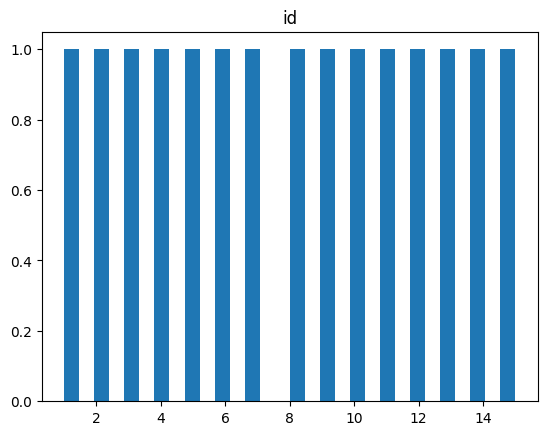

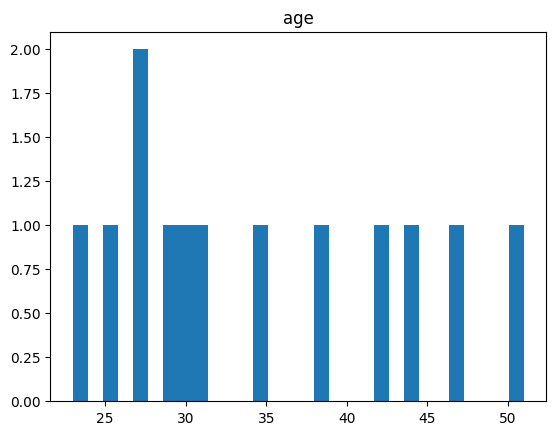

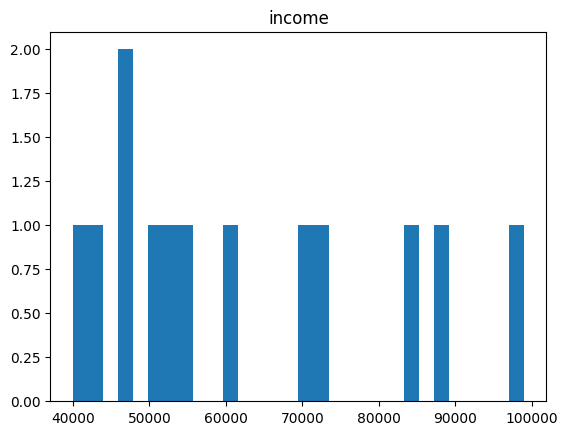

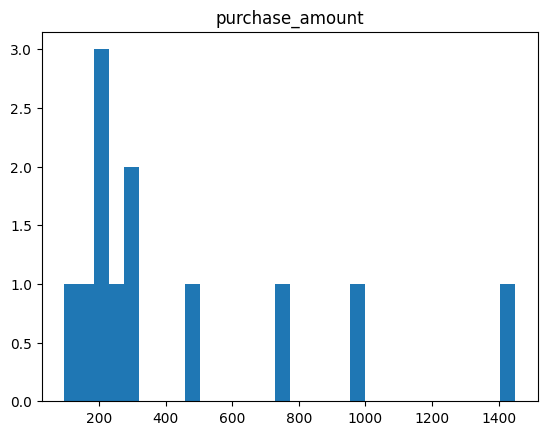

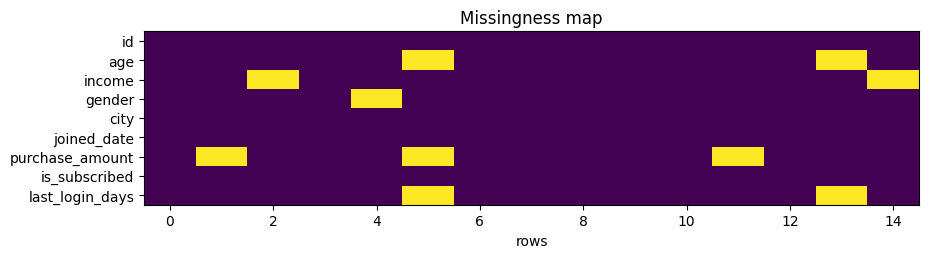

In [9]:
# Cell: generate and display visuals for quick demo
def save_hist(series, out_dir, name):
    path = Path(out_dir)/f"{name}_hist.png"
    plt.figure()
    try:
        series = series.dropna()
        plt.hist(series, bins=30)
        plt.title(name)
        plt.savefig(path, bbox_inches="tight")
    finally:
        plt.close()
    return str(path)

def save_missing_map(df, out_dir):
    path = Path(out_dir)/"missingness_map.png"
    plt.figure(figsize=(10, max(2, len(df.columns)*0.25)))
    plt.imshow(df.isna().T, aspect="auto", interpolation="nearest")
    plt.yticks(range(len(df.columns)), df.columns)
    plt.xlabel("rows")
    plt.title("Missingness map")
    plt.savefig(path, bbox_inches="tight")
    plt.close()
    return str(path)

# generate visuals for first up to 4 numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()[:4]
visual_paths = []
for c in num_cols:
    p = save_hist(df[c], IMAGES_DIR, c.replace(" ", "_"))
    visual_paths.append(p)

# missingness map
visual_paths.append(save_missing_map(df, IMAGES_DIR))

# display examples inline
for p in visual_paths:
    display(Image(p, width=600))


In [10]:
# Cell: ask Gemini to take the profile and return structured recommendations
prompt_intro = """
You are a concise data-quality assistant. Input: `profile_json` that lists
columns with dtype, pct_missing, n_unique, and simple stats.
Return a JSON object with key "recommendations" containing a list where each entry:
- column: <column name>
- issue: one-line issue summary
- recommendation: one-line suggested remediation (e.g., median impute, drop column)
Do not return any extra text outside the JSON.
"""

input_payload = {
    "prompt_intro": prompt_intro,
    "profile": profile
}

# Compose the content; using string because some SDK versions expect text
contents = prompt_intro + "\n\n" + json.dumps(profile)

resp = client.models.generate_content(
    model="gemini-2.5-flash",  # adjust model as desired
    contents=contents
)

# Extract text and parse robustly
raw_text = getattr(resp, "text", None) or getattr(resp, "output", None) or str(resp)
if isinstance(raw_text, list): raw_text = raw_text[0]
if hasattr(resp, "text") and not raw_text:
    raw_text = resp.text

reco_json = safe_json_load(raw_text)
print("Parsed Gemini response (keys):", list(reco_json.keys()) if isinstance(reco_json, dict) else type(reco_json))
reco_json


Parsed Gemini response (keys): ['recommendations']


{'recommendations': [{'column': 'age',
   'issue': 'Missing values detected (13.3% missing).',
   'recommendation': 'Impute missing values with the median.'},
  {'column': 'income',
   'issue': 'Missing values detected (13.3% missing).',
   'recommendation': 'Impute missing values with the median.'},
  {'column': 'gender',
   'issue': 'Missing values detected (6.7% missing).',
   'recommendation': 'Impute missing values with the mode.'},
  {'column': 'joined_date',
   'issue': 'Column is of object type but represents a date.',
   'recommendation': 'Convert column to datetime type.'},
  {'column': 'purchase_amount',
   'issue': 'Significant missing values detected (20.0% missing).',
   'recommendation': 'Impute missing values with the median.'},
  {'column': 'is_subscribed',
   'issue': 'Column is of object type but represents a boolean value.',
   'recommendation': 'Convert column to boolean type.'},
  {'column': 'last_login_days',
   'issue': 'Missing values detected (13.3% missing).'

In [11]:
# Cell: assemble and save final report
report = {
    "profile": profile,
    "recommendations_from_gemini": reco_json,
    "visuals": visual_paths
}
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
with open(f"{OUT_DIR}/sample_report.json", "w") as f:
    json.dump(report, f, indent=2)

print("Saved report:", f"{OUT_DIR}/sample_report.json")
display(JSON(report))


Saved report: examples/sample_report.json


<IPython.core.display.JSON object>

In [12]:
# Cell: helper to ask Gemini again with stricter prompt if parsing failed
def ask_gemini_strict(profile, max_attempts=2):
    attempts=0
    while attempts<max_attempts:
        attempts+=1
        contents = "Return ONLY valid JSON (no commentary). Schema: {recommendations:[{column,issue,recommendation}]}\n\n" + json.dumps(profile)
        r = client.models.generate_content(model="gemini-2.5-flash", contents=contents)
        txt = getattr(r,"text", str(r))
        parsed = safe_json_load(txt)
        if isinstance(parsed, dict) and "recommendations" in parsed:
            return parsed
    return {"error": "could-not-parse", "raw": txt}

# try re-ask if needed
if not (isinstance(reco_json, dict) and "recommendations" in reco_json):
    reco_json = ask_gemini_strict(profile, max_attempts=2)
    print("Re-ask result keys:", reco_json.keys() if isinstance(reco_json, dict) else type(reco_json))


In [13]:
# Cell: very simple checks to include in your notebook for judges
errors = []
if profile["n_rows"] <= 0:
    errors.append("no-rows")
if profile["n_columns"] <= 0:
    errors.append("no-columns")
if not Path(OUT_DIR + "/sample_report.json").exists():
    errors.append("report-not-saved")

print("Basic checks OK" if not errors else "Checks failed: " + ", ".join(errors))


Basic checks OK
